# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 3: Deep Learning

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 08 de agosto de 2024


<div style="text-align: center;">
    <h1>✍️ Discusión / Cálculos - [Deep Learning] ✍️</h1>
</div>

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.models import Model

import os
import json

%matplotlib inline

### 📚 Carga de datasets 

In [89]:
csvPath = 'Consumo/dataConsumo.csv'
dataConsumo = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

csvPath = 'Importacion/dataImportacion.csv'
dataImportacion = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

csvPath = 'PreciosPromedioNacionales/dataPrecios.csv'
dataPrecios = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

✅ Archivo cargado: Consumo/dataConsumo.csv
✅ Archivo cargado: Importacion/dataImportacion.csv
✅ Archivo cargado: PreciosPromedioNacionales/dataPrecios.csv


In [90]:
serieConsumoDiesel = dataConsumo[['Fecha', 'Diesel']]
serieImportacionRegular = dataImportacion[['Fecha', 'Gasolina regular']]
seriePreciosSuper = dataPrecios[['FECHA', 'Superior GTQ/GALON']]
serieConsumoDiesel.set_index('Fecha', inplace=True)
serieConsumoDiesel.sort_index(inplace=True)
serieImportacionRegular.set_index('Fecha', inplace=True)
serieImportacionRegular.sort_index(inplace=True)
seriePreciosSuper.set_index('FECHA', inplace=True)
seriePreciosSuper.sort_index(inplace=True)

In [91]:
def pruebaDickeyFuller(serieTiempo, descripcion):
    print(f"📊 Prueba de Dickey-Fuller Aumentada para: {descripcion}")
    resultado = adfuller(serieTiempo)
    print(f'Estadístico ADF: {resultado[0]}')
    print(f'p-valor: {resultado[1]}')
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'  {key}: {value}')
    print('-----------------------------------------------------')
    return resultado[1] 

print('-----------------------------------------------------')
pruebaDickeyFuller(serieConsumoDiesel['Diesel'], 'Diesel')
pruebaDickeyFuller(serieImportacionRegular['Gasolina regular'], 'Regular')
pruebaDickeyFuller(seriePreciosSuper['Superior GTQ/GALON'], 'Superior')

-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: 0.14523982117810716
p-valor: 0.9690175028779467
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Regular
Estadístico ADF: 0.8288289928204905
p-valor: 0.992087554110633
Valores críticos:
  1%: -3.4547128138328875
  5%: -2.8722649771800155
  10%: -2.5724850011573914
-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -2.9399220843939617
p-valor: 0.040898674582741115
Valores críticos:
  1%: -3.435401880796999
  5%: -2.863770985550096
  10%: -2.567957791647768
-----------------------------------------------------


0.040898674582741115

Realizando las pruebas de Dickey-Fuller para cada una de las series de tiempo. Podemos ver que el valor p tanto para la serie de tiempo para **diesel** y para **regular** es bastante alta, por lo que nos puede indicar que ambas series no son estacionarias, lo que nos sugiere que para volverlas estacionarias se le pueden hacer transformaciones como la diferenciación. Ahora con la serie de tiempo para **superior** podemos ver que el valor p es mucho menos, diciendonos que es más probable que sí sea estacionaria.

In [92]:
def detectar_valores_invalidos(serieTemporal, descripcion):
    serieTemporal = pd.to_numeric(serieTemporal, errors='coerce')  # Convertir a numérico y forzar NaN si hay errores
    n_nan = serieTemporal.isna().sum()
    n_no_positivos = (serieTemporal <= 0).sum()

    print(f"🔍 Detección de valores inválidos en la serie: {descripcion}")
    print(f"  Valores NaN: {n_nan}")
    print(f"  Valores no positivos: {n_no_positivos}")
    
    serieTemporal_sin_nan = serieTemporal.dropna()
    print(f"  Serie temporal sin valores NaN tiene {len(serieTemporal_sin_nan)} elementos.")
    
    return serieTemporal_sin_nan, n_nan, n_no_positivos

def varianza_estable(serieTemporal):
    n = len(serieTemporal)
    partes = np.array_split(serieTemporal, 3)
    varianzas = [np.var(parte) for parte in partes]
    return np.allclose(varianzas[0], varianzas[1], rtol=0.1) and np.allclose(varianzas[1], varianzas[2], rtol=0.1)

def aplicar_transformacion_logaritmica(serieTemporal):
    if (serieTemporal > 0).all():
        return np.log(serieTemporal)
    else:
        print("⚠️ La serie contiene valores no positivos, no se puede aplicar la transformación logarítmica.")
        return serieTemporal

def analizar_y_transformar_serie(serieTemporal, descripcion):
    print(f"🔍 Analizando la serie: {descripcion}")
    
    serieTemporal, n_nan, n_no_positivos = detectar_valores_invalidos(serieTemporal, descripcion)
    
    estacionaria = False
    intentos = 0
    max_intentos = 10
    diferencia_contador = 0  # Contador de diferenciaciones

    serieTemporal = aplicar_transformacion_logaritmica(serieTemporal)
    
    while not estacionaria and intentos < max_intentos:
        intentos += 1
        p_valor = pruebaDickeyFuller(serieTemporal, descripcion)
        if p_valor < 0.05:
            if varianza_estable(serieTemporal):
                estacionaria = True
                print(f"✅ La serie {descripcion} es estacionaria en media y varianza.")
                break
            else:
                print(f"❌ La varianza no es estable en la serie {descripcion}.")
        else:
            print(f"❌ La serie {descripcion} no es estacionaria (p-valor: {p_valor}).")
        
        serieTemporal = serieTemporal.diff().dropna()
        diferencia_contador += 1  # Incrementar el contador de diferenciación
        print(f"🔄 Aplicando diferenciación a {descripcion}. Intento {intentos}.")
    
    if not estacionaria:
        print(f"⚠️ No se pudo hacer la serie {descripcion} estacionaria después de {max_intentos} intentos.")
        print("📈 Utilizando un modelo ARIMA para tratar con la no estacionariedad.")
        modelo_arima = ARIMA(serieTemporal, order=(1, 1, 1))
        modelo_arima_fit = modelo_arima.fit()
        print(modelo_arima_fit.summary())
    else:
        modelo_arima_fit = None
        
    return serieTemporal, modelo_arima_fit, diferencia_contador


# Asegúrate de que estas variables estén definidas correctamente
# Reemplaza con tus series temporales reales
serieTemporalD, modelo_arima_diesel, contDiffDiesel = analizar_y_transformar_serie(serieConsumoDiesel['Diesel'], 'Diesel')
# print("--------------------------------------------------------------------------------------------------------")
serieTemporalR, modelo_arima_regular, contDiffRegular = analizar_y_transformar_serie(serieImportacionRegular['Gasolina regular'], 'Regular')
# print("--------------------------------------------------------------------------------------------------------")
serieTemporalS, modelo_arima_super, contDiffDiesel = analizar_y_transformar_serie(seriePreciosSuper['Superior GTQ/GALON'], 'Superior')


🔍 Analizando la serie: Diesel
🔍 Detección de valores inválidos en la serie: Diesel
  Valores NaN: 0
  Valores no positivos: 0
  Serie temporal sin valores NaN tiene 293 elementos.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -0.44918144412882166
p-valor: 0.901557753919378
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
❌ La serie Diesel no es estacionaria (p-valor: 0.901557753919378).
🔄 Aplicando diferenciación a Diesel. Intento 1.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -6.9885899777221345
p-valor: 7.851113111171977e-10
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
❌ La varianza no es estable en la serie Diesel.
🔄 Aplicando diferenciación a Diesel. Intento 2.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -9.12656830456

c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecate

                               SARIMAX Results                                
Dep. Variable:                 Diesel   No. Observations:                  283
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1078.599
Date:                Thu, 08 Aug 2024   AIC                           2163.197
Time:                        23:20:55   BIC                           2174.123
Sample:                    11-01-2000   HQIC                          2167.578
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8892      0.027    -32.441      0.000      -0.943      -0.836
ma.L1         -0.9995      1.502     -0.665      0.506      -3.944       1.945
sigma2       119.3735    179.118      0.666      0.5

c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecate

Estadístico ADF: -3.1808885678115097
p-valor: 0.021117919557505475
Valores críticos:
  1%: -3.435401880796999
  5%: -2.863770985550096
  10%: -2.567957791647768
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄 Aplicando diferenciación a Superior. Intento 1.
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -9.560298586241815
p-valor: 2.436091753573115e-16
Valores críticos:
  1%: -3.435401880796999
  5%: -2.863770985550096
  10%: -2.567957791647768
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄 Aplicando diferenciación a Superior. Intento 2.
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -12.012324756428338
p-valor: 3.159810795761913e-22
Valores críticos:
  1%: -3.435469111362934
  5%: -2.8638006501960755
  10%: -2.567973589477539
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄

c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecate

Estadístico ADF: -24.442636534117085
p-valor: 0.0
Valores críticos:
  1%: -3.4354892269437243
  5%: -2.863809525815561
  10%: -2.5679783161860823
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄 Aplicando diferenciación a Superior. Intento 7.
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -26.56196458544625
p-valor: 0.0
Valores críticos:
  1%: -3.4354932690454993
  5%: -2.863811309309343
  10%: -2.5679792659863123
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄 Aplicando diferenciación a Superior. Intento 8.
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -28.2528211841386
p-valor: 0.0
Valores críticos:
  1%: -3.435497317510684
  5%: -2.8638130956084464
  10%: -2.5679802172809003
-----------------------------------------------------
❌ La varianza no es estable en la serie Superior.
🔄 Aplicando diferenciación a Superior. Intento 9.
📊

c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Documentos\Semestre8\DataScience\Laboratorios\Lab03_Data-Science\venv\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecate

                               SARIMAX Results                                
Dep. Variable:     Superior GTQ/GALON   No. Observations:                 1295
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1718.628
Date:                Thu, 08 Aug 2024   AIC                           3443.255
Time:                        23:20:56   BIC                           3458.752
Sample:                    01-11-2021   HQIC                          3449.071
                         - 07-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9007      0.006   -148.573      0.000      -0.913      -0.889
ma.L1         -0.9999      1.317     -0.759      0.448      -3.581       1.581
sigma2         0.8275      1.089      0.760      0.4

Como se mencionó anteriormente la serie temporal de **diesel** no es estacionaria, por lo qie se realizaron 10 intentos de diferenciación para tratar de transformarla. Se pudo notar que el estadístico ADF fue mejorando progresivamente pero la varianza no era estable, por lo que no se logró una estacionaridad deseada. Se aplicó un modelo ARIMA la cual mostró una alta desviación estándar indicando alta incertidumbre en las predicciones.

Para la serie temporal de **regular** también se determinó que no es estacionaria. Se le realizó el mismo procedimiento que a la serie temporal de **diesel** pero tampoco se logró la estacionaridad deseada. También se implemento un modelo ARIMA lo cual indica casi lo mismo que en la otra serie que puede tener una alta incertidumbre en predicciones.

A pesar de que el p valor de la serie de tiempo de **superior** era bastante pequeño con las pruebas anteriores se pudo ver que tampoco era estacionaria. Por ello también se le procedió a hacer los 10 intentos de diferenciaciones, la cual tampoco se lograron grandes resultados como con las anteriores. Se le realizó igualmente un modelo ARIMA la cual también indica que puede tener alta incertidumbre en predicciones.

### 🧪 Division train y test

In [93]:
print(contDiffDiesel, contDiffRegular, contDiffSuper)

10 10 1


A continuación se realizará la separación de train y test como se indica proximamente, así como la transformación a 3D y los modelos que se habías realizado previamente en el laboratorio pasado

In [94]:
# Dividir los datos en 70% entrenamiento, 15% validación y 15% prueba
def dividir_datos(serie, caso='general'):
    if caso == 'general':
        # Dividir hasta el 31 de diciembre de 2021 para entrenamiento
        train = serie[:'2020-12-31']
        # El resto será el conjunto de prueba
        test = serie['2021-01-01':]

    elif caso == 'precios':
        # Dividir hasta el 31 de diciembre de 2023 para entrenamiento
        train = serie[:'2023-12-31']
        # El resto será el conjunto de prueba (2024)
        test = serie['2024-01-01':]

    return train, test


In [95]:
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


In [96]:
def toDataframe(serie):
    if not isinstance(serie, pd.DataFrame):
        print("📝 Convirtiendo a DataFrame")
        return serie.to_frame()
    return serie

In [97]:
print(serieTemporalD)
print(serieTemporalR)
print(serieTemporalS)

Fecha
2000-11-01    32.049649
2000-12-01   -11.704332
2001-01-01    -3.911316
2001-02-01    12.343220
2001-03-01   -17.003987
                ...    
2024-01-01     6.039414
2024-02-01   -15.269101
2024-03-01    26.414247
2024-04-01   -26.526294
2024-05-01    17.610983
Name: Diesel, Length: 283, dtype: float64
Fecha
2001-11-01     54.404698
2001-12-01    -66.523856
2002-01-01    107.894447
2002-02-01   -142.345927
2002-03-01    141.693651
                 ...    
2024-01-01    -16.347663
2024-02-01     30.262647
2024-03-01    -23.924004
2024-04-01     -4.881117
2024-05-01     40.242851
Name: Gasolina regular, Length: 271, dtype: float64
FECHA
2021-01-11    0.021671
2021-01-12   -0.195041
2021-01-13    0.780166
2021-01-14   -1.820387
2021-01-15    2.730581
                ...   
2024-07-24   -0.496552
2024-07-25    1.119677
2024-07-26   -1.679516
2024-07-27    1.679516
2024-07-28   -1.119677
Name: Superior GTQ/GALON, Length: 1295, dtype: float64


### 📅 Datasets diesel y regular test 3 ultimos años y test 2024 para super.

In [98]:
scaler = StandardScaler()

# Diesel
print("⛽ Preparando datos Diesel")
serieTemporalDG = toDataframe(serieTemporalD)
serieTemporalDScaledG = scaler.fit_transform(serieTemporalDG)
serieTemporalDScaledG = pd.DataFrame(serieTemporalDScaledG, index=serieTemporalDG.index, columns=serieTemporalDG.columns)

trainL3DG, testL3DG = dividir_datos(serieTemporalDScaledG)
print(f"  Datos de entrenamiento: {trainL3DG.shape}")
print(f"  Datos de prueba: {testL3DG.shape}")

x_trainDG, y_trainDG = supervisada(trainL3DG.values)
x_testDG, y_testDG = supervisada(testL3DG.values)

print(testL3DG)
print("📊 Formato de los datos")
print(f"  x_trainDG: {x_trainDG.shape}")
print(f"  y_trainDG: {y_trainDG.shape}")
print(f"  x_testDG: {x_testDG.shape}")
print(f"  y_testDG: {y_testDG.shape}")

⛽ Preparando datos Diesel
📝 Convirtiendo a DataFrame
  Datos de entrenamiento: (242, 1)
  Datos de prueba: (41, 1)
              Diesel
Fecha               
2021-01-01  0.364622
2021-02-01  0.252176
2021-03-01 -0.900977
2021-04-01  1.292475
2021-05-01 -1.201467
2021-06-01  0.562750
2021-07-01  0.239138
2021-08-01 -0.755253
2021-09-01  0.833671
2021-10-01 -0.798743
2021-11-01  0.824557
2021-12-01 -0.797863
2022-01-01  0.505213
2022-02-01 -0.044534
2022-03-01 -0.442039
2022-04-01  0.774301
2022-05-01 -0.823662
2022-06-01  0.522334
2022-07-01 -0.193365
2022-08-01  0.154558
2022-09-01 -0.372255
2022-10-01  0.406929
2022-11-01 -0.043520
2022-12-01 -0.680788
2023-01-01  1.516016
2023-02-01 -2.149620
2023-03-01  2.185060
2023-04-01 -1.716478
2023-05-01  1.300003
2023-06-01 -1.457043
2023-07-01  2.012268
2023-08-01 -2.478599
2023-09-01  2.477777
2023-10-01 -2.014520
2023-11-01  1.217617
2023-12-01 -0.482195
2024-01-01  0.249464
2024-02-01 -0.645076
2024-03-01  1.104807
2024-04-01 -1.117657
202

In [99]:
# Gasolina Regular
print("⛽ Preparando datos Gasolina Regular")
serieTemporalRG = toDataframe(serieTemporalR)
serieTemporalRScaledG = scaler.fit_transform(serieTemporalRG)
serieTemporalRScaledG = pd.DataFrame(serieTemporalRScaledG, index=serieTemporalRG.index, columns=serieTemporalRG.columns)

trainL3RG, testL3RG = dividir_datos(serieTemporalRScaledG)

x_trainRG, y_trainRG = supervisada(trainL3RG.values)
x_testRG, y_testRG = supervisada(testL3RG.values)

print("📊 Formato de los datos")
print(f"  x_trainRG: {x_trainRG.shape}")
print(f"  y_trainRG: {y_trainRG.shape}")
print(f"  x_testRG: {x_testRG.shape}")
print(f"  y_testRG: {y_testRG.shape}")

⛽ Preparando datos Gasolina Regular
📝 Convirtiendo a DataFrame
📊 Formato de los datos
  x_trainRG: (229, 1)
  y_trainRG: (229,)
  x_testRG: (40, 1)
  y_testRG: (40,)


In [100]:
# Gasolina Superior
print("⛽ Preparando datos Gasolina Superior")
serieTemporalSP = toDataframe(serieTemporalS)
serieTemporalSScaledP = scaler.fit_transform(serieTemporalSP)
serieTemporalSScaledP = pd.DataFrame(serieTemporalSScaledP, index=serieTemporalSP.index, columns=serieTemporalSP.columns)

trainL3SP, testL3SP = dividir_datos(serieTemporalSScaledP, 'precios')

x_trainSP, y_trainSP = supervisada(trainL3SP.values)
x_testSP, y_testSP = supervisada(testL3SP.values)
print("📊 Formato de los datos")
print(f"  x_trainSP: {x_trainSP.shape}")
print(f"  y_trainSP: {y_trainSP.shape}")
print(f"  x_testSP: {x_testSP.shape}")
print(f"  y_testSP: {y_testSP.shape}")

⛽ Preparando datos Gasolina Superior
📝 Convirtiendo a DataFrame
📊 Formato de los datos
  x_trainSP: (1084, 1)
  y_trainSP: (1084,)
  x_testSP: (209, 1)
  y_testSP: (209,)


### 🌀 Transformando a 3D

In [101]:
import numpy as np

# Función para transformar matrices 2D en matrices 3D para LSTM
def transformar_a_3D(x):
    return np.reshape(x, (x.shape[0], 1, 1))

# Usando la función en los conjuntos de datos
def preparar_datos_lstm(x_train, y_train, x_test, y_test):
    print("🌀 Transformando a 3D...")    
    x_train_3D = transformar_a_3D(x_train)
    x_test_3D = transformar_a_3D(x_test)
    
    return x_train_3D, y_train, x_test_3D, y_test

# Diesel
x_trainD_3DG, y_trainDG, x_testD_3DG, y_testDG = preparar_datos_lstm(x_trainDG, y_trainDG, x_testDG, y_testDG)
print("⛽ Datos de diesel transformados.")  

print("📊 Formato de los datos")
print(f"  x_trainD_3DG: {x_trainD_3DG.shape}")
print(f"  y_trainDG: {y_trainDG.shape}")
print(f"  x_testD_3DG: {x_testD_3DG.shape}")
print(f"  y_testDG: {y_testDG.shape}")


# Gasolina Regular
x_trainR_3DG, y_trainRG, x_testR_3DG, y_testRG = preparar_datos_lstm(x_trainRG, y_trainRG, x_testRG, y_testRG)
print("⛽ Datos de gasolina regular transformados.")

# Gasolina Superior
x_trainS_3DG, y_trainSG, x_testS_3DG, y_testSG = preparar_datos_lstm(x_trainSP, y_trainSP, x_testSP, y_testSP)
print("⛽ Datos de gasolina superior transformados.")


🌀 Transformando a 3D...
⛽ Datos de diesel transformados.
📊 Formato de los datos
  x_trainD_3DG: (241, 1, 1)
  y_trainDG: (241,)
  x_testD_3DG: (40, 1, 1)
  y_testDG: (40,)
🌀 Transformando a 3D...
⛽ Datos de gasolina regular transformados.
🌀 Transformando a 3D...
⛽ Datos de gasolina superior transformados.


### 🚨 Creando modelos y entranando modelos...


In [102]:
import json
import os
import numpy as np
from keras.models import load_model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.models import Model

# Parámetros del modelo para ambos modelos
configuraciones = {
    'diesel': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1, 'tipo': 'simple'},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1, 'tipo': 'complejo'}  # Modelo 2
    ],
    'regular': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1, 'tipo': 'complejo'},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1, 'tipo': 'simple'}  # Modelo 2
    ],
    'superior': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1, 'tipo': 'simple'},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1, 'tipo': 'complejo'}  # Modelo 2
    ]
}

def guardar_historial(historial, nombre_archivo):
    with open(nombre_archivo, 'w') as f:
        json.dump(historial.history, f)
    print(f"📊 Historial guardado como {nombre_archivo}")

# Función para crear el modelo
def crear_modelo(paso, caracteristicas, unidades, tipo='simple'):
    inputs = Input(shape=(paso, caracteristicas))

    if tipo == 'simple':
        lstm_out = LSTM(unidades)(inputs)
        outputs = Dense(1)(lstm_out)

    elif tipo == 'complejo':
        lstm_out = LSTM(unidades, return_sequences=True)(inputs)
        lstm_out = Dropout(0.2)(lstm_out)
        lstm_out = LSTM(unidades)(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)
        outputs = Dense(1)(lstm_out)

    modelo = Model(inputs=inputs, outputs=outputs)
    modelo.summary()
    return modelo

# Función para guardar el modelo
def guardar_modelo(modelo, nombre_archivo):
    modelo.save(nombre_archivo)
    print(f"💾 Modelo guardado como {nombre_archivo}")

# Función para cargar el modelo si existe, de lo contrario crearlo
def cargar_o_crear_modelo(nombre_archivo, paso, caracteristicas, unidades, tipo):
    if os.path.exists(nombre_archivo):
        print(f"📂 Cargando modelo desde {nombre_archivo}")
        return load_model(nombre_archivo)
    else:
        print(f"🔧 Creando nuevo modelo")
        modelo = crear_modelo(paso, caracteristicas, unidades, tipo)
        return modelo

# Archivos de los modelos
archivos_modelo = {
    'diesel': ['modelo_diesel_1.h5', 'modelo_diesel_2.h5'],
    'regular': ['modelo_regular_1.h5', 'modelo_regular_2.h5'],
    'superior': ['modelo_superior_1.h5', 'modelo_superior_2.h5']
}

# Entrenamiento y evaluación de los modelos
for serie, modelos in archivos_modelo.items():
    for i, (config) in enumerate(configuraciones[serie]):
        archivo_modelo = modelos[i]
        modelo = cargar_o_crear_modelo(archivo_modelo, config['paso'], config['caracteristicas'], config['unidades'], config['tipo'])

        # Compilar el modelo
        modelo.compile(optimizer='adam', loss='mean_squared_error')

        print(serie[0].capitalize())

        # Entrenar y guardar el modelo si no ha sido entrenado antes
        if not os.path.exists(archivo_modelo):
            print(f"⛽ Entrenando modelo {i+1} para datos {serie.capitalize()}")
            history = modelo.fit(
                eval(f"x_train{serie[0].capitalize()}_3DG"), 
                eval(f"y_train{serie[0].capitalize()}G"), 
                epochs=50, 
                batch_size=config['lote']
            )
            guardar_historial(history, f'historial_{serie}_{i+1}.json')
            guardar_modelo(modelo, archivo_modelo)

        # Evaluar el modelo en el conjunto de prueba
        print("📈 Evaluando modelo")
        loss = modelo.evaluate(eval(f"x_test{serie[0].capitalize()}_3DG"), eval(f"y_test{serie[0].capitalize()}G"))
        print(f"📉 Pérdida para {serie.capitalize()} Modelo {i+1}: {loss}")


🔧 Creando nuevo modelo


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

D
⛽ Entrenando modelo 1 para datos Diesel
Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - loss: 0.8146
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.7654
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.7788 
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.6797
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.5243
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.5179
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.4185
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.3728
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.3379
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.2963
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.2889
Epoch 12/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.2917
Epoch 13/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3074
Epoch 14/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step -

📊 Historial guardado como historial_diesel_1.json
💾 Modelo guardado como modelo_diesel_1.h5
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2338  
📉 Pérdida para Diesel Modelo 1: 0.22660234570503235
🔧 Creando nuevo modelo


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

D
⛽ Entrenando modelo 2 para datos Diesel
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - loss: 1.1360
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.8978
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.7098
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.4388
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.2795 
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.2557
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.2959
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.3179
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2647
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.2976
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.2764
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.2514
Epoch 13/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.2900
Epoch 14/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - l

📊 Historial guardado como historial_diesel_2.json
💾 Modelo guardado como modelo_diesel_2.h5
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2167  
📉 Pérdida para Diesel Modelo 2: 0.21018850803375244
🔧 Creando nuevo modelo


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 1, 1)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

R
⛽ Entrenando modelo 1 para datos Regular
Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 1.1225
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 1.1862
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 1.1390
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.9330
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.0867
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.8339
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.7607
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.6493
Epoch 9/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.8742
Epoch 10/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.6707
Epoch 11/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.7748
Epoch 12/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.4707
Epoch 13/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.7054
Epoch 14/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step -

📊 Historial guardado como historial_regular_1.json
💾 Modelo guardado como modelo_regular_1.h5
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0410  
📉 Pérdida para Regular Modelo 1: 0.039049193263053894
🔧 Creando nuevo modelo


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

R
⛽ Entrenando modelo 2 para datos Regular
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 1.2410 
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 1.0017
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.6836
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 0.5319
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.3533
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.2067
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 0.1938
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1853
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.1987
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1883
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.1972
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.1726
Epoch 13/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.1750
Epoch 14/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step 

📊 Historial guardado como historial_regular_2.json
💾 Modelo guardado como modelo_regular_2.h5
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320  
📉 Pérdida para Regular Modelo 2: 0.030909601598978043
🔧 Creando nuevo modelo


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

S
⛽ Entrenando modelo 1 para datos Superior
Epoch 1/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 2s 654us/step - loss: 0.7495
Epoch 2/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.5699
Epoch 3/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 0.4868
Epoch 4/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.4546
Epoch 5/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 0.4135
Epoch 6/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 0.4503
Epoch 7/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 0.2971
Epoch 8/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - loss: 0.3332
Epoch 9/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.3770
Epoch 10/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - loss: 0.2980
Epoch 11/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 0.2694
Epoch 12/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 0.2669
Epoch 13/50
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.3018
Epoch 14/50
1084/1084 ━━━━━━━

📊 Historial guardado como historial_superior_1.json
💾 Modelo guardado como modelo_superior_1.h5
📈 Evaluando modelo
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0721
📉 Pérdida para Superior Modelo 1: 0.06212993338704109
🔧 Creando nuevo modelo


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

S
⛽ Entrenando modelo 2 para datos Superior
Epoch 1/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 776us/step - loss: 1.0594
Epoch 2/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.4460
Epoch 3/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.3972
Epoch 4/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.3320
Epoch 5/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.2673
Epoch 6/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.3077
Epoch 7/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.3282
Epoch 8/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.3106
Epoch 9/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.2727
Epoch 10/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.2875
Epoch 11/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.2927
Epoch 12/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.2746
Epoch 13/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.2527
Epoch 14/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step 

📊 Historial guardado como historial_superior_2.json
💾 Modelo guardado como modelo_superior_2.h5
📈 Evaluando modelo
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0803
📉 Pérdida para Superior Modelo 2: 0.06589370220899582


Como se puede ver anterioremente se realizaron 2 modelos por cada una de las series de tiempo. Como se puede ver cada modelo se guarda en un archivo .h5 y así evitar entrenarlos cada vez que se ejecute el programa. También se generaron archivos .json los cuales almacenan el historial dw entrenamiento de cada modelo así se puede utilizar para ver las métricas y gráficas como lo son la pérdida de los modelos.

### 👁️ Visualización de las pérdidas de los modelos.

In [103]:
def cargar_historial(nombre_archivo):
    with open(nombre_archivo, 'r') as f:
        return json.load(f)

historial_d1 = cargar_historial('historial_diesel_1.json')
historial_d2 = cargar_historial('historial_diesel_2.json') 
historial_r1 = cargar_historial('historial_regular_1.json')
historial_r2 = cargar_historial('historial_regular_2.json')
historial_s1 = cargar_historial('historial_superior_1.json')
historial_s2 = cargar_historial('historial_superior_2.json')

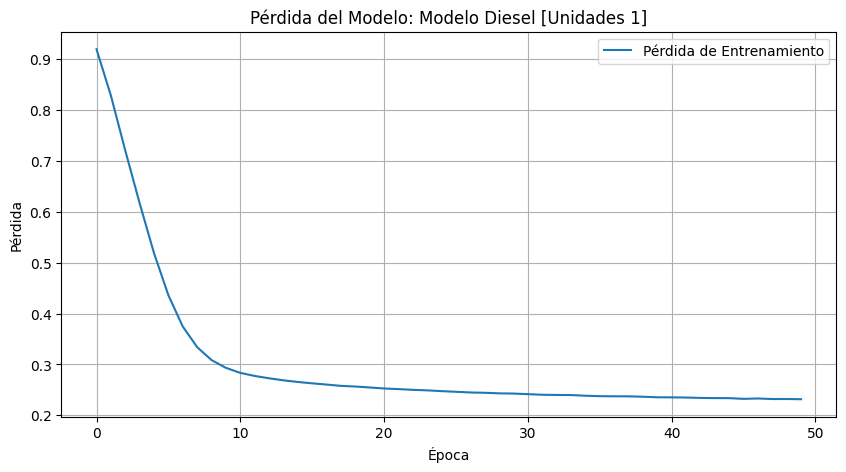

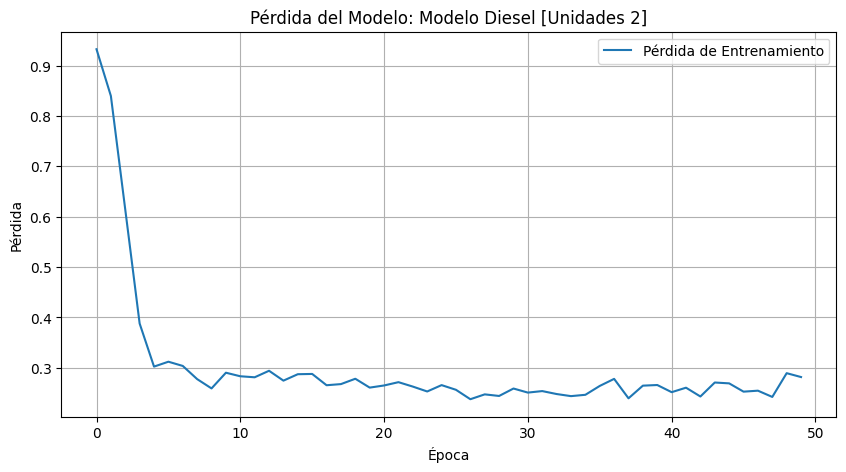

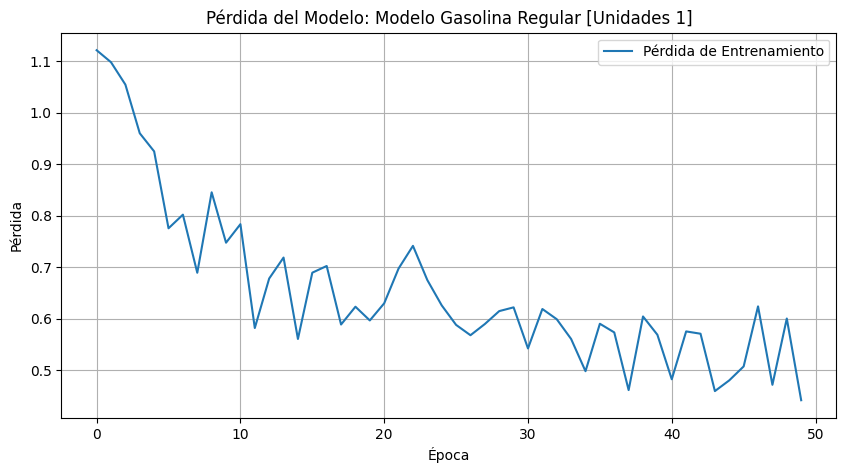

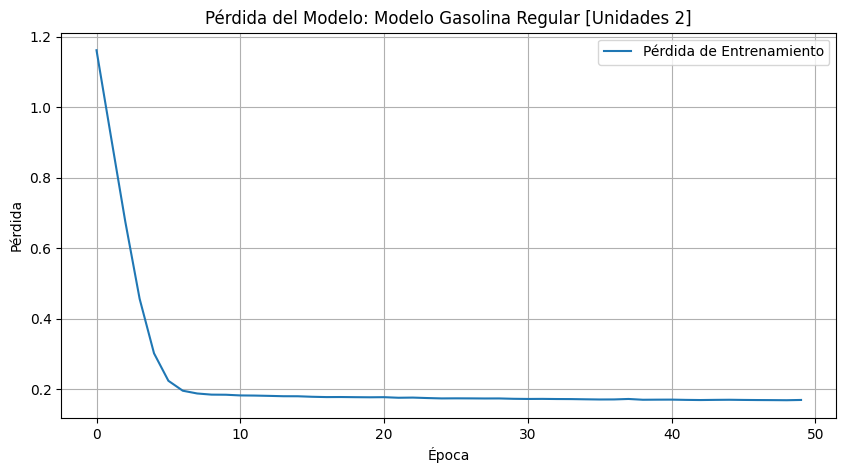

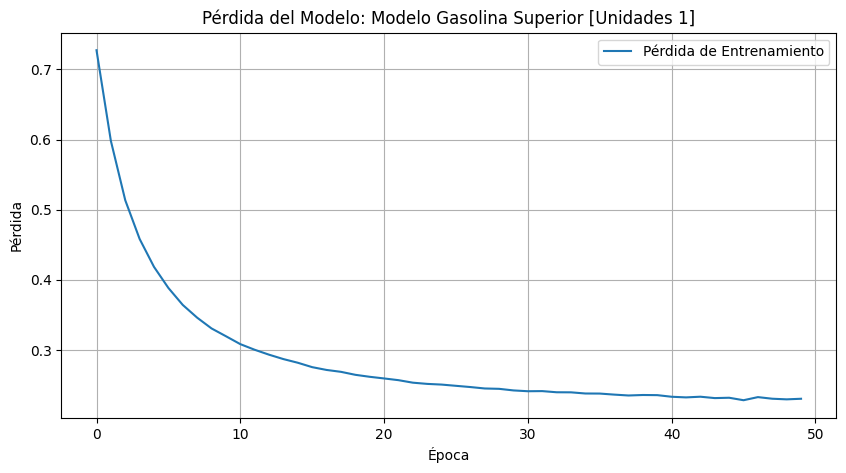

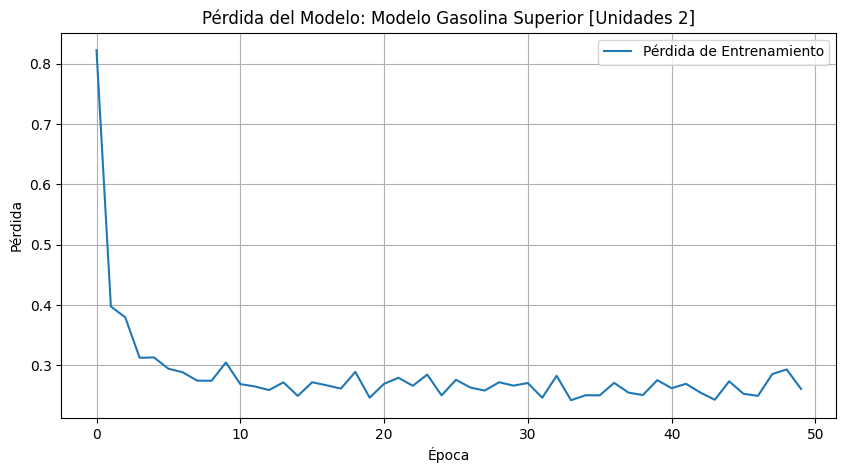

In [104]:
import matplotlib.pyplot as plt

def graficar_historial(historial, nombre_modelo):
    """
    Grafica la pérdida de entrenamiento a partir del historial del modelo.

    :param historial: El objeto de historial que se obtiene al entrenar el modelo.
    :param nombre_modelo: El nombre del modelo, usado para el título de la gráfica.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(historial['loss'], label='Pérdida de Entrenamiento')
    plt.title(f'Pérdida del Modelo: {nombre_modelo}')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

# Uso de la función
graficar_historial(historial_d1, 'Modelo Diesel [Unidades 1]')
graficar_historial(historial_d2, 'Modelo Diesel [Unidades 2]')
graficar_historial(historial_r1, 'Modelo Gasolina Regular [Unidades 1]')
graficar_historial(historial_r2, 'Modelo Gasolina Regular [Unidades 2]')
graficar_historial(historial_s1, 'Modelo Gasolina Superior [Unidades 1]')
graficar_historial(historial_s2, 'Modelo Gasolina Superior [Unidades 2]')

Para el modelo **diesel** de unidades 1, se puede ver que desciende rápidamenre durante las primeras 10 épocas estabilizandose cerca de 0.2 ya en las 50 épocas casi. Esto nos dice que el modelo aprende bastante rápido al principio, sin embargo la estabilizaciń al final puede indicar que hay un límite en la capacidad del modelo para mejorar despues de este punto.

Para el de unidades 2, la pérdida también disminuye rápidamente en las primeras 10 épocas estabilizandose al final con pequeñas flutuaciones. Esto podría indicar que a comparación del otro modelo que tiene mayor variabilidad en el aprendizaje, o también posibles problemas de sobreajuste en ciertas épocas.

Pasando con el modelo **regular** de unidades 1, y desciende con ciertas fluctuaciones estabilizandose despies de 50 épocas.Esta irregularidad en la disminución de la pérdida podría indicar que el modelo tiene dificultades para aprender ciertos patrones en los datos.

Para el de unidades 2 de este mismo se puede ver una pérdida que cae rápidamente en las primeras 10 épocas y luego se estabiliza. Esto indica que el modelo pudo haber encontrado un buen ajuste de entrenamiento y por donde se estabilizo puede ser posible que haya un margen de mejora.

Por último con el modelo **superior** de unidades 1, se empieza a ver una pérdida que disminuye rápidamente estabilizandose cerca de 0.3, viendo ciertas variaciones hasta llegar a la época 50. Esto nos muestra que el modelo aprende bastante rápido lo cual es bueno, mostrando una pérdida mínima más baja.

Luego con el modelo de unidades 2 para etse mismo podemos ver que la perdida baja bruscamente luego de 0.3 con ciertas fluctuaciones, sin grandes cambios tampoco, lo que puede indicar cierta estabilidad pero también variabilidad.

📂 Cargando modelo desde modelo_diesel_1.h5
📂 Cargando modelo desde modelo_diesel_2.h5
📂 Cargando modelo desde modelo_regular_1.h5
📂 Cargando modelo desde modelo_regular_2.h5
📂 Cargando modelo desde modelo_superior_1.h5
📂 Cargando modelo desde modelo_superior_2.h5
Diesel [Unidades 1] (241, 1, 1) (241,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Diesel [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2300
📊 Pérdida de Prueba: 0.2266

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
📊 Predicciones para Diesel [Unidades 1]: [0.7060049  0.79393774 2.4089065  0.3125815  2.972474   0.57758737
 0.8048984  2.1444979  0.44772586 2.2223725  0.45137012 2.2207878
 0.61163914 1.085753   1.620993   0.47229606 2.2674215  0.60124296
 1.2669642  0.88003385 1.5154638  0.67586297 1.0845997  2.0136518
 0.272016   4.591752   0.20371333 3.9085329  0.31100234 3.4485917
 0.21599275 5.0286226  0.18835242 4.3914948  0.32921368 1.6837542
 0.7962042  1.9521517  0.35777506 2.8143613 ]
📉 MAE para Diesel

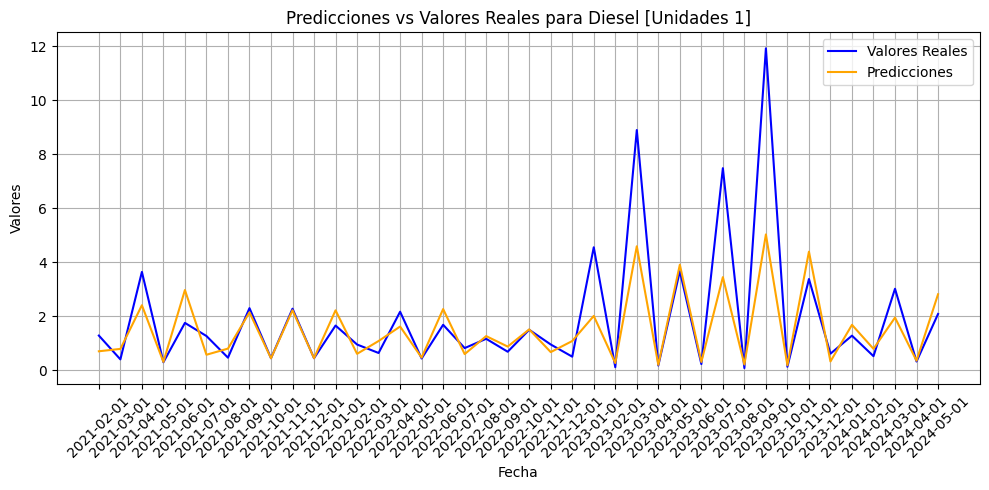

Diesel [Unidades 2] (241, 1, 1) (241,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Diesel [Unidades 2]
📊 Pérdida de Entrenamiento: 0.2180
📊 Pérdida de Prueba: 0.2102

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
📊 Predicciones para Diesel [Unidades 2]: [0.7153211  0.7912618  2.1957765  0.3283688  2.7968864  0.60009515
 0.8006054  1.9422195  0.47511256 2.0153115  0.47878492 2.0138113
 0.6312819  1.0346515  1.4785534  0.49965718 2.0581777  0.621816
 1.1835688  0.86408836 1.3895916  0.6888106  1.0337026  1.8221039
 0.27845794 5.295558   0.18201391 4.058184   0.32649368 3.3888583
 0.20112208 6.297482   0.15607163 4.896713   0.3478318  1.5320325
 0.79319584 1.7667288  0.38016194 2.6186695 ]
📉 MAE para Diesel [Unidades 2]: 1.2123



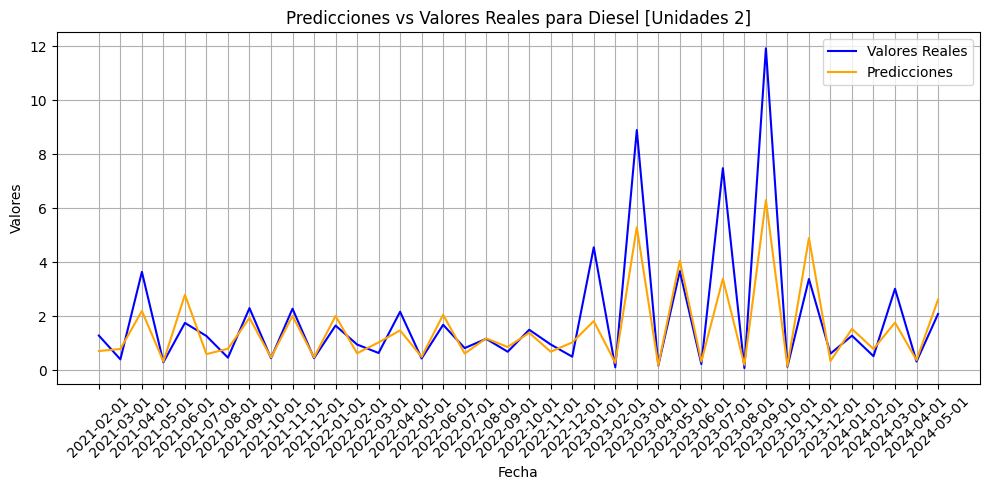

Gasolina Regular [Unidades 1] (229, 1, 1) (229,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Gasolina Regular [Unidades 1]
📊 Pérdida de Entrenamiento: 0.3139
📊 Pérdida de Prueba: 0.0390

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
📊 Predicciones para Gasolina Regular [Unidades 1]: [1.7331824  0.63027066 1.6755702  0.6378879  1.5384774  0.78459454
 1.1083441  1.0843595  0.9444374  1.0653399  0.9359202  1.3541079
 0.6197061  1.9146707  0.5770354  1.5667168  0.78351223 1.2121586
 0.9414606  1.0194131  1.0010017  1.289676   0.61471325 2.0399733
 0.520297   1.7832555  0.7219771  1.2477384  0.8675477  1.2415757
 0.8501141  1.1572284  0.9465104  1.1046087  0.9494549  1.0383673
 1.1147459  0.8721981  1.1601865  1.0491345 ]
📉 MAE para Gasolina Regular [Unidades 1]: 0.4563



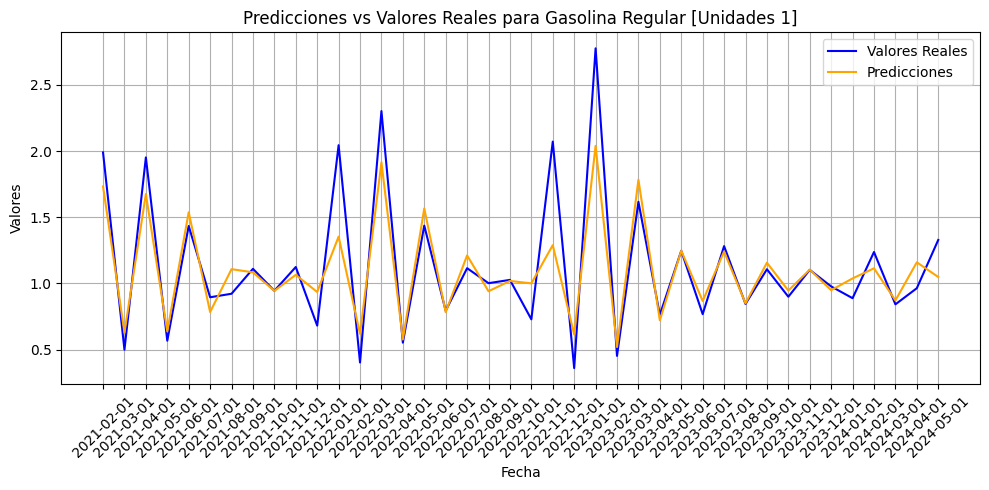

Gasolina Regular [Unidades 2] (229, 1, 1) (229,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Gasolina Regular [Unidades 2]
📊 Pérdida de Entrenamiento: 0.1668
📊 Pérdida de Prueba: 0.0309

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
📊 Predicciones para Gasolina Regular [Unidades 2]: [2.1073606  0.4967534  2.0029202  0.50608015 1.766281   0.6878517
 1.1136925  1.0805818  0.8928256  1.0545288  0.88167024 1.47157
 0.48383057 2.4579868  0.4317583  1.8137239  0.686492   1.2605262
 0.8889236  0.9923327  0.9676718  1.3742057  0.47772783 2.7213995
 0.36269894 2.2007165  0.6096916  1.3122525  0.7931257  1.303239
 0.77081776 1.1821003  0.8955451  1.1085163  0.89941084 1.0178815
 1.1225797  0.7990942  1.186281   1.0324693 ]
📉 MAE para Gasolina Regular [Unidades 2]: 0.5317



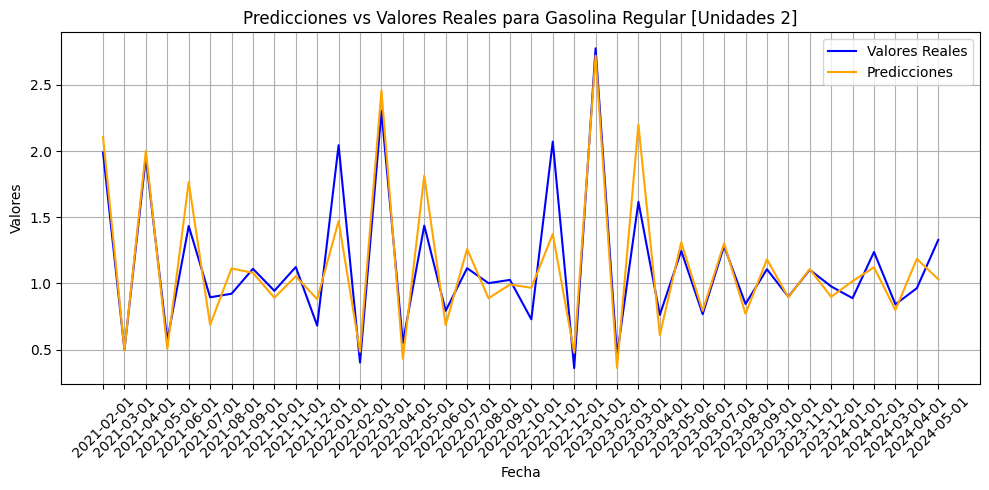

Gasolina Superior [Unidades 1] (1084, 1, 1) (1084,) (209, 1, 1) (209,) 209
🔍 Evaluando el modelo - Gasolina Superior [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2281
📊 Pérdida de Prueba: 0.0621

🔍 Realizando predicciones...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
📊 Predicciones para Gasolina Superior [Unidades 1]: [16.092295    0.12651809  2.764606    0.79167837  1.0301691   1.0584252
  0.96042603  1.0791957   0.97926664  1.0351753   1.0138432   1.0185453
  1.0180742   1.0180742   1.0209116   0.99289113  1.1253549   0.80618656
  1.4443902   0.71790403  1.2859054   0.9124784   1.1356909   0.7255633
  2.210525    0.3266652   3.1875432   0.469893    1.4236616   0.9447901
  0.98907566  1.1131501   0.8905465   1.1639395   0.9311457   1.0500156
  1.077574    0.7820211   1.8810859   0.41093752  2.529687    0.55174625
  1.3269206   0.9539982   1.0201118   1.0309216   0.99910367  1.0374062
  1.0053873   1.0160093   1.0867705   0.7804543   1.8858093   0.4094586
  2.5388827   0.55037045  1.3193521  

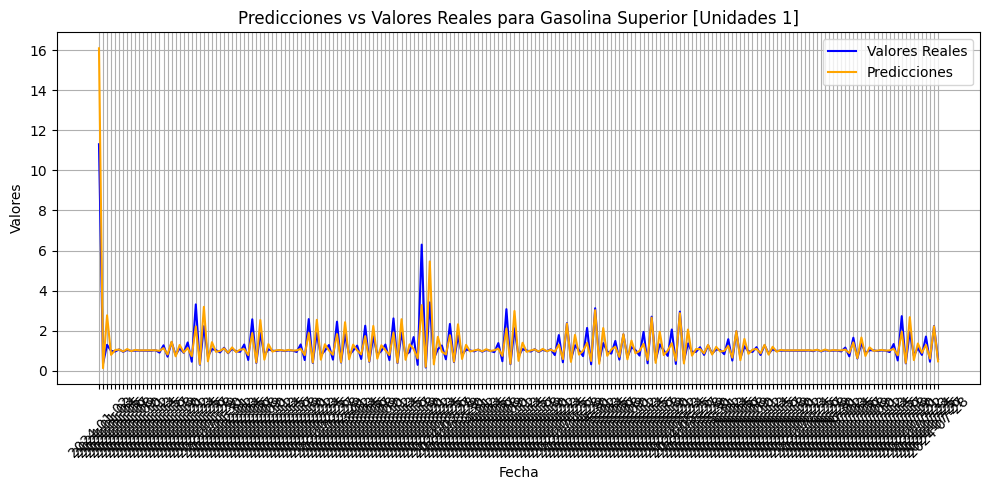

Gasolina Superior [Unidades 2] (1084, 1, 1) (1084,) (209, 1, 1) (209,) 209
🔍 Evaluando el modelo - Gasolina Superior [Unidades 2]
📊 Pérdida de Entrenamiento: 0.2132
📊 Pérdida de Prueba: 0.0659

🔍 Realizando predicciones...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📊 Predicciones para Gasolina Superior [Unidades 2]: [23.979242    0.11081348  2.7719693   0.78348905  1.0164579   1.0440711
  0.9483351   1.0643759   0.96673477  1.0213495   1.0005078   1.0051014
  1.004641    1.004641    1.007413    0.98004156  1.1095258   0.7976747
  1.4231      0.7112722   1.2669405   0.9015137   1.1196414   0.71877754
  2.1939595   0.32165515  3.2262566   0.46633512  1.4026242   0.9330662
  0.97631484  1.097584    0.880096    1.1472987   0.91974247  1.0358517
  1.0627903   0.774044    1.8588299   0.40720713  2.5246053   0.54771274
  1.3072712   0.9420581   1.0066317   1.0171931   0.9861096   1.0235294
  0.99224746  1.0026239   1.0717826   0.77251136  1.8635929   0.40571713
  2.5342236   0.5463506   1.2998248 

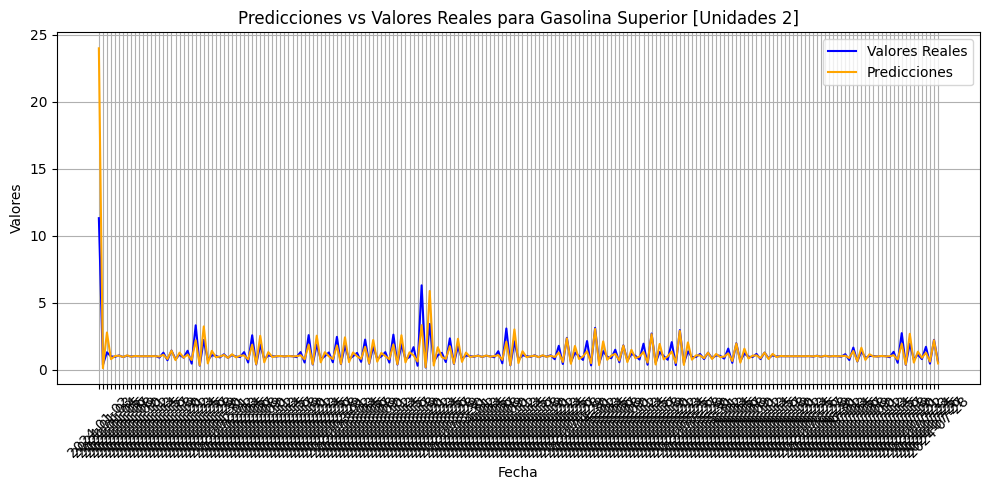

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

def deshacer_transformacion_logaritmica(serieTransformada):
    return np.exp(serieTransformada)

def hacer_predicciones(modelo, xTest, yTest):
    print("🔍 Realizando predicciones...")
    
    # Hacer predicciones
    predicciones = modelo.predict(xTest)

    # Calcular MAE
    mae = np.mean(np.abs(predicciones - yTest))

    return predicciones, mae

def graficar_predicciones(fecha, y_test, predicciones, nombre):
    plt.figure(figsize=(10, 5))
    plt.plot(fecha, y_test, label='Valores Reales', color='blue')
    plt.plot(fecha, predicciones, label='Predicciones', color='orange')
    plt.title(f'Predicciones vs Valores Reales para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Cargar los modelos
modelo_d1 = onlyLoadModelo('modelo_diesel_1.h5')
modelo_d2 = onlyLoadModelo('modelo_diesel_2.h5')
modelo_r1 = onlyLoadModelo('modelo_regular_1.h5')
modelo_r2 = onlyLoadModelo('modelo_regular_2.h5')
modelo_s1 = onlyLoadModelo('modelo_superior_1.h5') 
modelo_s2 = onlyLoadModelo('modelo_superior_2.h5')

# Compilar los modelos
for modelo in [modelo_d1, modelo_d2, modelo_r1, modelo_r2, modelo_s1, modelo_s2]:
    modelo.compile(optimizer='adam', loss='mean_squared_error')

# Evaluar los modelos y hacer predicciones
for modelo, nombre, x_train, y_train, x_test, y_test, test_set in [
    (modelo_d1, 'Diesel [Unidades 1]', x_trainD_3DG, y_trainDG, x_testD_3DG, y_testDG, testL3DG),
    (modelo_d2, 'Diesel [Unidades 2]', x_trainD_3DG, y_trainDG, x_testD_3DG, y_testDG, testL3DG),
    (modelo_r1, 'Gasolina Regular [Unidades 1]', x_trainR_3DG, y_trainRG, x_testR_3DG, y_testRG, testL3RG),
    (modelo_r2, 'Gasolina Regular [Unidades 2]', x_trainR_3DG, y_trainRG, x_testR_3DG, y_testRG, testL3RG),
    (modelo_s1, 'Gasolina Superior [Unidades 1]', x_trainS_3DG, y_trainSG, x_testS_3DG, y_testSG, testL3SP),
    (modelo_s2, 'Gasolina Superior [Unidades 2]', x_trainS_3DG, y_trainSG, x_testS_3DG, y_testSG, testL3SP)
]:
    fechas = test_set.index  # Obtener las fechas del conjunto de prueba
    fechas = fechas[1:]
    print(nombre, x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(fechas))
    evaluarModelo(modelo, nombre, x_train, y_train, x_test, y_test)
    
    # Hacer predicciones
    predicciones, mae = hacer_predicciones(modelo, x_test, y_test)
    
    # Deshacer la transformación logarítmica
    predicciones_desh = deshacer_transformacion_logaritmica(predicciones)
    y_test_desh = deshacer_transformacion_logaritmica(y_test)

    print(f"📊 Predicciones para {nombre}: {predicciones_desh.flatten()}")
    print(f"📉 MAE para {nombre}: {mae:.4f}\n")
    
    # Graficar las predicciones
    graficar_predicciones(fechas, y_test_desh, predicciones_desh, nombre)



In [105]:
from keras.models import load_model
import os

def onlyLoadModelo(nombre_archivo):
    if os.path.exists(nombre_archivo):
        print(f"📂 Cargando modelo desde {nombre_archivo}")
        return load_model(nombre_archivo)
    else:
        print(f"❌ Modelo no encontrado")
        return None  # Devolver None si el modelo no se encuentra

📂 Cargando modelo desde modelo_diesel_1.h5
📂 Cargando modelo desde modelo_diesel_2.h5
📂 Cargando modelo desde modelo_regular_1.h5
📂 Cargando modelo desde modelo_regular_2.h5
📂 Cargando modelo desde modelo_superior_1.h5
📂 Cargando modelo desde modelo_superior_2.h5
Diesel [Unidades 1] (241, 1, 1) (241,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Diesel [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2300
📊 Pérdida de Prueba: 0.2266

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
📊 Predicciones para Diesel [Unidades 1]: [0.7060049  0.79393774 2.4089065  0.3125815  2.972474   0.57758737
 0.8048984  2.1444979  0.44772586 2.2223725  0.45137012 2.2207878
 0.61163914 1.085753   1.620993   0.47229606 2.2674215  0.60124296
 1.2669642  0.88003385 1.5154638  0.67586297 1.0845997  2.0136518
 0.272016   4.591752   0.20371333 3.9085329  0.31100234 3.4485917
 0.21599275 5.0286226  0.18835242 4.3914948  0.32921368 1.6837542
 0.7962042  1.9521517  0.35777506 2.8143613 ]
📉 MAE para Diesel

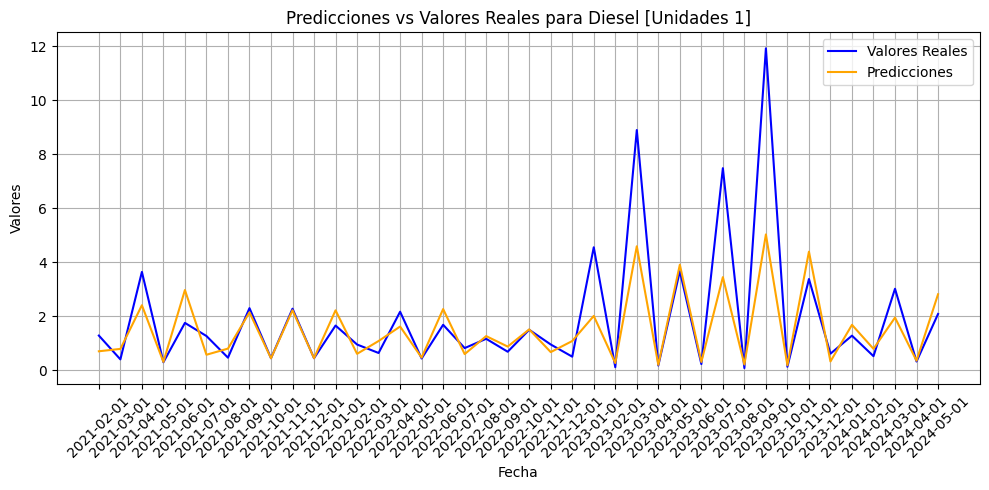

Diesel [Unidades 2] (241, 1, 1) (241,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Diesel [Unidades 2]
📊 Pérdida de Entrenamiento: 0.2180
📊 Pérdida de Prueba: 0.2102

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
📊 Predicciones para Diesel [Unidades 2]: [0.7153211  0.7912618  2.1957765  0.3283688  2.7968864  0.60009515
 0.8006054  1.9422195  0.47511256 2.0153115  0.47878492 2.0138113
 0.6312819  1.0346515  1.4785534  0.49965718 2.0581777  0.621816
 1.1835688  0.86408836 1.3895916  0.6888106  1.0337026  1.8221039
 0.27845794 5.295558   0.18201391 4.058184   0.32649368 3.3888583
 0.20112208 6.297482   0.15607163 4.896713   0.3478318  1.5320325
 0.79319584 1.7667288  0.38016194 2.6186695 ]
📉 MAE para Diesel [Unidades 2]: 1.2123



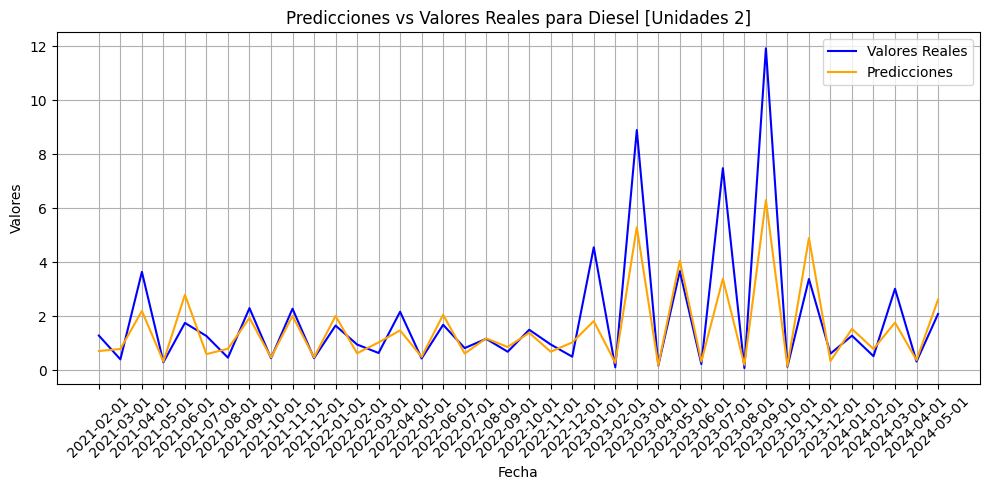

Gasolina Regular [Unidades 1] (229, 1, 1) (229,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Gasolina Regular [Unidades 1]
📊 Pérdida de Entrenamiento: 0.3139
📊 Pérdida de Prueba: 0.0390

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
📊 Predicciones para Gasolina Regular [Unidades 1]: [1.7331824  0.63027066 1.6755702  0.6378879  1.5384774  0.78459454
 1.1083441  1.0843595  0.9444374  1.0653399  0.9359202  1.3541079
 0.6197061  1.9146707  0.5770354  1.5667168  0.78351223 1.2121586
 0.9414606  1.0194131  1.0010017  1.289676   0.61471325 2.0399733
 0.520297   1.7832555  0.7219771  1.2477384  0.8675477  1.2415757
 0.8501141  1.1572284  0.9465104  1.1046087  0.9494549  1.0383673
 1.1147459  0.8721981  1.1601865  1.0491345 ]
📉 MAE para Gasolina Regular [Unidades 1]: 0.4563



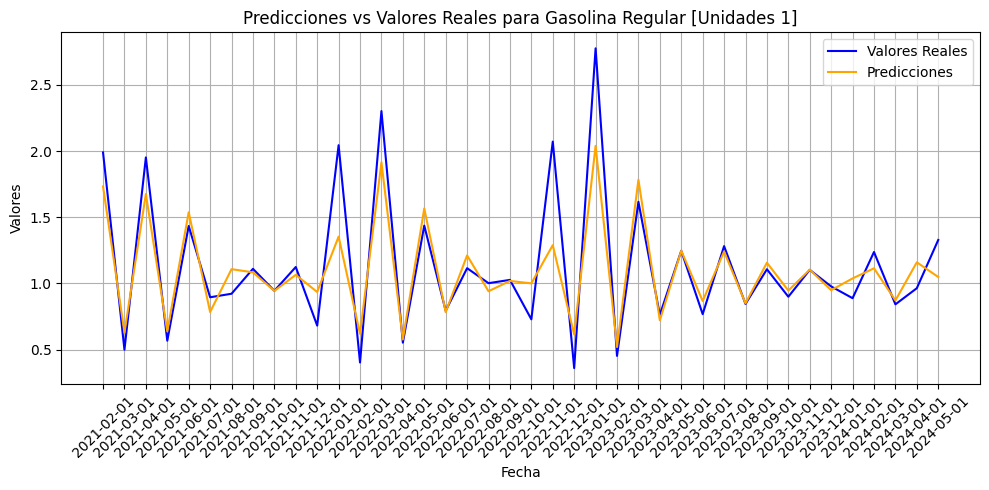

Gasolina Regular [Unidades 2] (229, 1, 1) (229,) (40, 1, 1) (40,) 40
🔍 Evaluando el modelo - Gasolina Regular [Unidades 2]
📊 Pérdida de Entrenamiento: 0.1668
📊 Pérdida de Prueba: 0.0309

🔍 Realizando predicciones...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
📊 Predicciones para Gasolina Regular [Unidades 2]: [2.1073606  0.4967534  2.0029202  0.50608015 1.766281   0.6878517
 1.1136925  1.0805818  0.8928256  1.0545288  0.88167024 1.47157
 0.48383057 2.4579868  0.4317583  1.8137239  0.686492   1.2605262
 0.8889236  0.9923327  0.9676718  1.3742057  0.47772783 2.7213995
 0.36269894 2.2007165  0.6096916  1.3122525  0.7931257  1.303239
 0.77081776 1.1821003  0.8955451  1.1085163  0.89941084 1.0178815
 1.1225797  0.7990942  1.186281   1.0324693 ]
📉 MAE para Gasolina Regular [Unidades 2]: 0.5317



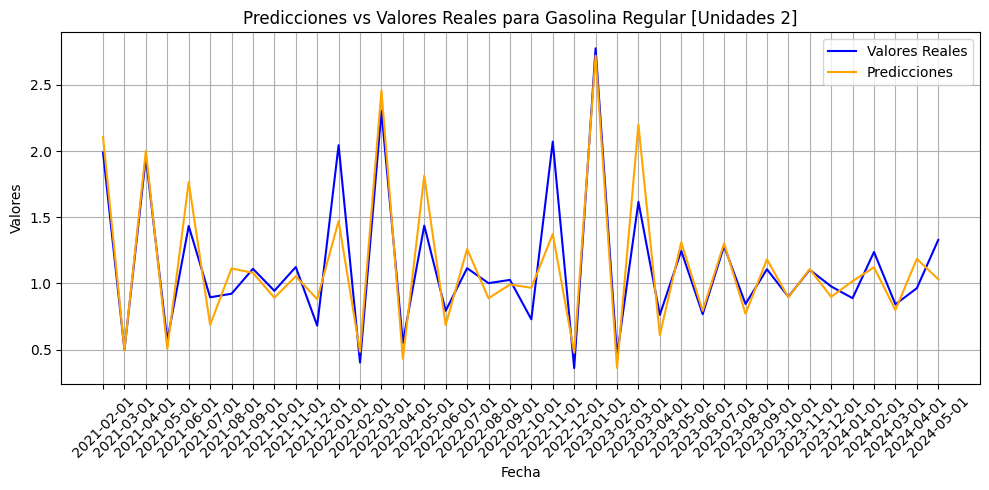

Gasolina Superior [Unidades 1] (1084, 1, 1) (1084,) (209, 1, 1) (209,) 209
🔍 Evaluando el modelo - Gasolina Superior [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2281
📊 Pérdida de Prueba: 0.0621

🔍 Realizando predicciones...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
📊 Predicciones para Gasolina Superior [Unidades 1]: [16.092295    0.12651809  2.764606    0.79167837  1.0301691   1.0584252
  0.96042603  1.0791957   0.97926664  1.0351753   1.0138432   1.0185453
  1.0180742   1.0180742   1.0209116   0.99289113  1.1253549   0.80618656
  1.4443902   0.71790403  1.2859054   0.9124784   1.1356909   0.7255633
  2.210525    0.3266652   3.1875432   0.469893    1.4236616   0.9447901
  0.98907566  1.1131501   0.8905465   1.1639395   0.9311457   1.0500156
  1.077574    0.7820211   1.8810859   0.41093752  2.529687    0.55174625
  1.3269206   0.9539982   1.0201118   1.0309216   0.99910367  1.0374062
  1.0053873   1.0160093   1.0867705   0.7804543   1.8858093   0.4094586
  2.5388827   0.55037045  1.3193521  

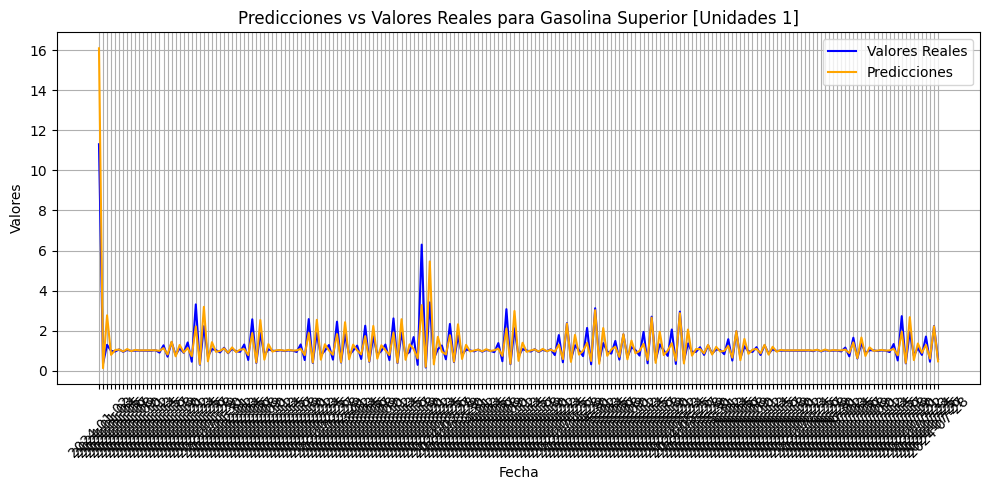

Gasolina Superior [Unidades 2] (1084, 1, 1) (1084,) (209, 1, 1) (209,) 209
🔍 Evaluando el modelo - Gasolina Superior [Unidades 2]
📊 Pérdida de Entrenamiento: 0.2132
📊 Pérdida de Prueba: 0.0659

🔍 Realizando predicciones...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📊 Predicciones para Gasolina Superior [Unidades 2]: [23.979242    0.11081348  2.7719693   0.78348905  1.0164579   1.0440711
  0.9483351   1.0643759   0.96673477  1.0213495   1.0005078   1.0051014
  1.004641    1.004641    1.007413    0.98004156  1.1095258   0.7976747
  1.4231      0.7112722   1.2669405   0.9015137   1.1196414   0.71877754
  2.1939595   0.32165515  3.2262566   0.46633512  1.4026242   0.9330662
  0.97631484  1.097584    0.880096    1.1472987   0.91974247  1.0358517
  1.0627903   0.774044    1.8588299   0.40720713  2.5246053   0.54771274
  1.3072712   0.9420581   1.0066317   1.0171931   0.9861096   1.0235294
  0.99224746  1.0026239   1.0717826   0.77251136  1.8635929   0.40571713
  2.5342236   0.5463506   1.2998248 

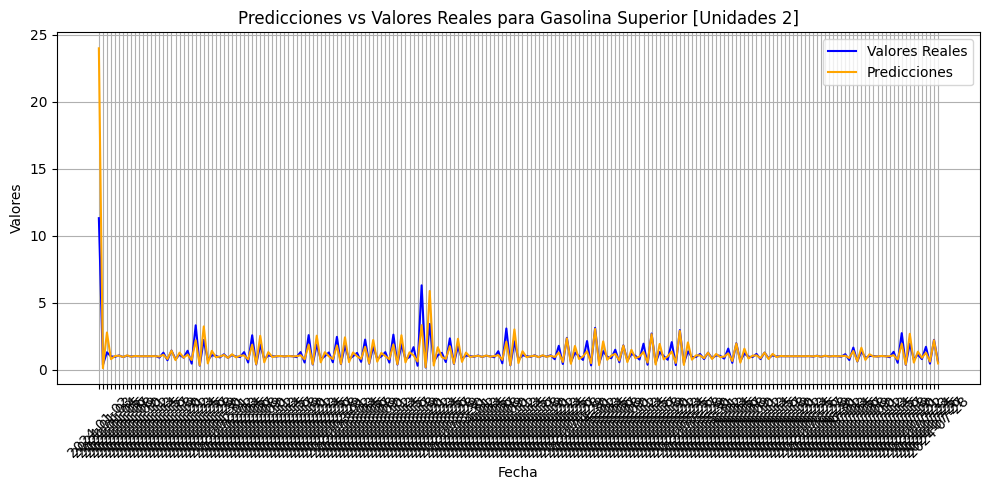

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

def deshacer_transformacion_logaritmica(serieTransformada):
    return np.exp(serieTransformada)

def hacer_predicciones(modelo, xTest, yTest):
    print("🔍 Realizando predicciones...")
    
    # Hacer predicciones
    predicciones = modelo.predict(xTest)

    # Calcular MAE
    mae = np.mean(np.abs(predicciones - yTest))

    return predicciones, mae

def graficar_predicciones(fecha, y_test, predicciones, nombre):
    plt.figure(figsize=(10, 5))
    plt.plot(fecha, y_test, label='Valores Reales', color='blue')
    plt.plot(fecha, predicciones, label='Predicciones', color='orange')
    plt.title(f'Predicciones vs Valores Reales para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Cargar los modelos
modelo_d1 = onlyLoadModelo('modelo_diesel_1.h5')
modelo_d2 = onlyLoadModelo('modelo_diesel_2.h5')
modelo_r1 = onlyLoadModelo('modelo_regular_1.h5')
modelo_r2 = onlyLoadModelo('modelo_regular_2.h5')
modelo_s1 = onlyLoadModelo('modelo_superior_1.h5') 
modelo_s2 = onlyLoadModelo('modelo_superior_2.h5')

# Compilar los modelos
for modelo in [modelo_d1, modelo_d2, modelo_r1, modelo_r2, modelo_s1, modelo_s2]:
    modelo.compile(optimizer='adam', loss='mean_squared_error')

# Evaluar los modelos y hacer predicciones
for modelo, nombre, x_train, y_train, x_test, y_test, test_set in [
    (modelo_d1, 'Diesel [Unidades 1]', x_trainD_3DG, y_trainDG, x_testD_3DG, y_testDG, testL3DG),
    (modelo_d2, 'Diesel [Unidades 2]', x_trainD_3DG, y_trainDG, x_testD_3DG, y_testDG, testL3DG),
    (modelo_r1, 'Gasolina Regular [Unidades 1]', x_trainR_3DG, y_trainRG, x_testR_3DG, y_testRG, testL3RG),
    (modelo_r2, 'Gasolina Regular [Unidades 2]', x_trainR_3DG, y_trainRG, x_testR_3DG, y_testRG, testL3RG),
    (modelo_s1, 'Gasolina Superior [Unidades 1]', x_trainS_3DG, y_trainSG, x_testS_3DG, y_testSG, testL3SP),
    (modelo_s2, 'Gasolina Superior [Unidades 2]', x_trainS_3DG, y_trainSG, x_testS_3DG, y_testSG, testL3SP)
]:
    fechas = test_set.index  # Obtener las fechas del conjunto de prueba
    fechas = fechas[1:]
    print(nombre, x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(fechas))
    evaluarModelo(modelo, nombre, x_train, y_train, x_test, y_test)
    
    # Hacer predicciones
    predicciones, mae = hacer_predicciones(modelo, x_test, y_test)
    
    # Deshacer la transformación logarítmica
    predicciones_desh = deshacer_transformacion_logaritmica(predicciones)
    y_test_desh = deshacer_transformacion_logaritmica(y_test)

    print(f"📊 Predicciones para {nombre}: {predicciones_desh.flatten()}")
    print(f"📉 MAE para {nombre}: {mae:.4f}\n")
    
    # Graficar las predicciones
    graficar_predicciones(fechas, y_test_desh, predicciones_desh, nombre)

